In [64]:
# ==============================================================
# 0. Imports & global knobs
# ==============================================================
import numpy as np, pandas as pd, torch, time, matplotlib.pyplot as plt
from torch.distributions import Beta
from torch.autograd.functional import hessian
torch.set_default_dtype(torch.double)

N_ASSETS   = 6
R_RATE     = 0.03
N_PATHS_AAD= 60_000          # paths for AAD / pathwise
SEED_BASE  = 42
torch.manual_seed(SEED_BASE)
np.random.seed(SEED_BASE)


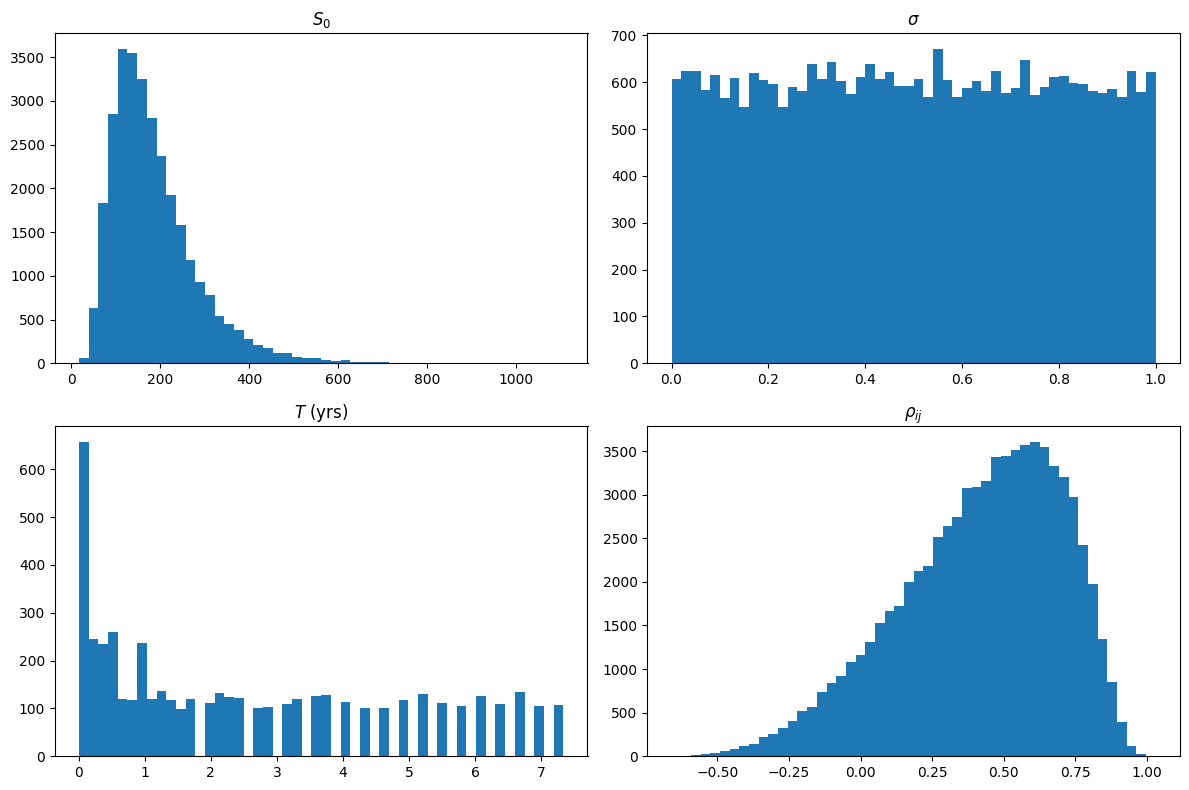

In [65]:

# ==============================================================
# 1. Ferguson–Green sampler  (+ sanity-check plots)
# ==============================================================
def fg_sample(n_assets=N_ASSETS):
    Z      = np.random.normal(0.5, np.sqrt(0.25), n_assets)
    S0     = 100*np.exp(Z)
    sigma  = np.random.uniform(0,1,n_assets)
    X      = np.random.randint(1,44)
    T      = (X**2)/252.0
    beta   = Beta(torch.tensor([5.]), torch.tensor([2.]))
    C      = torch.eye(n_assets, dtype=torch.double)
    for i in range(n_assets):
        for j in range(i+1,n_assets):
            C[i,j] = C[j,i] = 2*beta.sample().item() - 1
    # project to SPD
    ev, evec = torch.linalg.eigh(C)
    C = evec @ torch.diag(torch.clamp(ev, min=1e-4)) @ evec.T
    return dict(S0=S0, sigma=sigma, T=T, rho=C.numpy(), K=100.0)

# --- one-time distribution plots (skip when scaling) -----------
if True:
    N_DIAG = 5_000
    S0s,sigs,Ts,rhos=[],[],[],[]
    for _ in range(N_DIAG):
        q=fg_sample()
        S0s.extend(q['S0']); sigs.extend(q['sigma']); Ts.append(q['T'])
        rhos.extend(q['rho'][np.triu_indices(N_ASSETS,1)])
    fig,ax=plt.subplots(2,2,figsize=(12,8))
    ax[0,0].hist(S0s ,50); ax[0,0].set_title('$S_0$')
    ax[0,1].hist(sigs,50); ax[0,1].set_title('$\\sigma$')
    ax[1,0].hist(Ts  ,50); ax[1,0].set_title('$T$ (yrs)')
    ax[1,1].hist(rhos,50); ax[1,1].set_title('$\\rho_{ij}$')
    plt.tight_layout(); plt.show()


In [70]:

# ==============================================================
# 2. Vectorised Monte-Carlo path engine
#    (accepts optional Z for common-random-numbers)
# ==============================================================
def mc_paths(S0, sigma, T, rho, n_paths, n_steps=64, r=R_RATE, Z=None):
    d, dt = S0.numel(), T / n_steps
    chol  = torch.linalg.cholesky(rho)
    if Z is None:
        Z = torch.randn(n_paths, n_steps, d)
    Z = Z @ chol.T
    s = S0.repeat(n_paths, 1)
    drift  = (r - 0.5 * sigma**2) * dt
    vol_dt = sigma * torch.sqrt(dt)
    for t in range(n_steps):
        # -------- no in-place *=  --------
        s = s * torch.exp(drift + vol_dt * Z[:, t, :])
    return s.mean(dim=1)



In [74]:
# ==============================================================  
# 3. AAD / pathwise Greeks – NON-zero Gamma                      #
# ==============================================================  
from torch.autograd.functional import hessian

def greeks_aad(p, n_paths=N_PATHS_AAD):
    S0    = torch.tensor(p['S0'],    requires_grad=True)
    sigma = torch.tensor(p['sigma'], requires_grad=True)
    T     = torch.tensor(p['T'],     requires_grad=True)
    r     = torch.tensor(R_RATE,     requires_grad=True)
    rho_m = torch.tensor(p['rho'])
    K     = p['K']

    # forward pass
    basket = mc_paths(S0, sigma, T, rho_m, n_paths, r=r)
    price  = (torch.exp(-r*T) * torch.clamp(basket-K, 0)).mean()

    # first-order Greeks (one reverse sweep — true AAD)
    dS0, dSig, dr, dT = torch.autograd.grad(
        price, (S0, sigma, r, T), create_graph=True
    )

    # diagonal Gamma via Hessian (6×6, cheap)
    def price_vs_S0(x):
        b = mc_paths(x, sigma.detach(), T.detach(), rho_m, n_paths, r=r.detach())
        return (torch.exp(-r.detach()*T.detach()) * torch.clamp(b-K, 0)).mean()

    gamma_diag = hessian(price_vs_S0, S0).diagonal().detach().numpy()

    return dict(price = price.item(),
                delta = dS0.detach().numpy(),
                gamma = gamma_diag,
                vega  = dSig.detach().numpy(),
                rho   = dr.item(),
                theta = dT.item())


In [75]:

# ==============================================================
# 4. Fast CRN finite differences  (Δ Γdiag ν ρ θ)
# ==============================================================
def greeks_fd_fast(p, eps=1e-4, n_paths=40_000, n_steps=64):
    d       = N_ASSETS
    S0      = torch.tensor(p['S0'])
    sigma0  = torch.tensor(p['sigma'])
    T0      = torch.tensor(p['T'])
    rho_m   = torch.tensor(p['rho'])
    K       = 100.0
    r0      = R_RATE

    # ---------- build batched params (1+4d+4) -------------------
    n_batch  = 1 + 4*d + 4
    S0_mat   = S0.repeat(n_batch,1)
    sig_mat  = sigma0.repeat(n_batch,1)
    T_vec    = T0.repeat(n_batch)
    r_vec    = torch.full((n_batch,), r0, dtype=torch.double)

    # bumps for S0 (Δ,Γ)
    for i in range(d):
        h = eps*S0[i]
        S0_mat[1+2*i,   i] += h
        S0_mat[1+2*i+1, i] -= h
    # bumps for sigma (ν)
    for i in range(d):
        h = eps*max(sigma0[i],1e-2)
        j = 1+2*d+2*i
        sig_mat[j,   i] += h
        sig_mat[j+1, i] -= h
    # bump T (θ)
    hT = eps*T0
    idx_Tu, idx_Td = 1+4*d, 2+4*d
    T_vec[idx_Tu] += hT
    T_vec[idx_Td]  = torch.clamp(T_vec[idx_Td]-hT, min=1e-4)
    # bump r (ρ)
    hr = 1e-4
    idx_ru, idx_rd = idx_Td+1, idx_Td+2
    r_vec[idx_ru] += hr
    r_vec[idx_rd] -= hr

    # ---------- one CRN tensor shared ---------------------------
    Z = torch.randn(n_paths, n_steps, d)
    prices = torch.empty(n_batch)

    for j in range(n_batch):
        basket = mc_paths(S0_mat[j], sig_mat[j], T_vec[j], rho_m,
                          n_paths, n_steps, r=r_vec[j], Z=Z)
        prices[j] = (torch.exp(-r_vec[j]*T_vec[j]) *
                     torch.clamp(basket-K,0)).mean()

    base = prices[0].item()
    # Deltas & Gammas
    delta, gamma = [], []
    for i in range(d):
        h = eps*S0[i].item()
        up, dn = prices[1+2*i].item(), prices[1+2*i+1].item()
        delta.append((up-dn)/(2*h))
        gamma.append((up-2*base+dn)/(h*h))
    # Vegas
    vega=[]
    for i in range(d):
        h = eps*max(sigma0[i].item(),1e-2)
        j = 1+2*d+2*i
        up, dn = prices[j].item(), prices[j+1].item()
        vega.append((up-dn)/(2*h))
    # Theta & Rho
    theta = (prices[idx_Tu].item()-prices[idx_Td].item())/(2*hT.item())
    rho_g = (prices[idx_ru].item()-prices[idx_rd].item())/(2*hr)

    return dict(price=base,
                delta=np.array(delta),
                gamma=np.array(gamma),
                vega =np.array(vega),
                rho  =rho_g,
                theta=theta)


Price 133.3976
Δ  max |err| 2.23e-02
Γ  max |err| 3.76e-04
ν  max |err| 1.29e+01
ρ  |err|       1.14e+00
θ  |err|       9.46e-01
Timing  AAD 1.82s  |  FD 2.52s


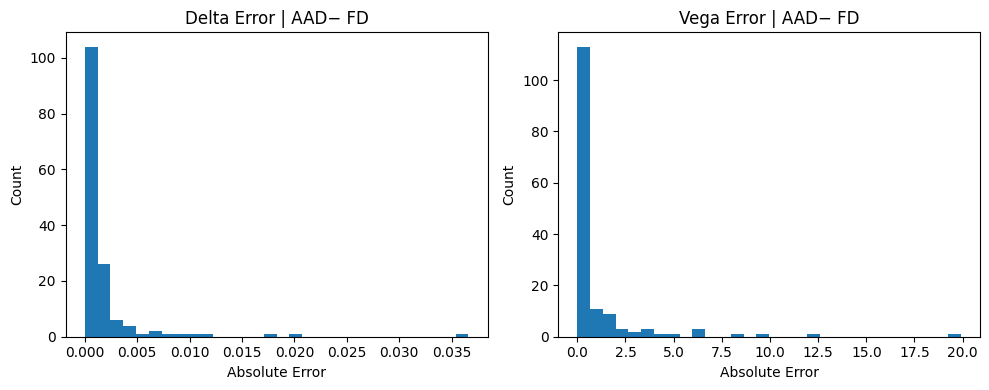

In [76]:

# ==============================================================
# 5. Speed & accuracy benchmark
# ==============================================================
p_test = fg_sample()
t0=time.perf_counter(); g_aad = greeks_aad(p_test); t_aad=time.perf_counter()-t0
t0=time.perf_counter(); g_fd  = greeks_fd_fast(p_test); t_fd =time.perf_counter()-t0

print(f"Price {g_aad['price']:.4f}")
print(f"Δ  max |err| {np.abs(g_aad['delta']-g_fd['delta']).max():.2e}")
print(f"Γ  max |err| {np.abs(g_aad['gamma']-g_fd['gamma']).max():.2e}")
print(f"ν  max |err| {np.abs(g_aad['vega'] -g_fd['vega'] ).max():.2e}")
print(f"ρ  |err|      {abs(g_aad['rho']  -g_fd['rho'] ): .2e}")
print(f"θ  |err|      {abs(g_aad['theta']-g_fd['theta']): .2e}")
print(f"Timing  AAD {t_aad:.2f}s  |  FD {t_fd:.2f}s")

# quick error histograms (M small for speed)
M=25
err_d,err_v=[],[]
for _ in range(M):
    q = fg_sample()
    a = greeks_aad(q, n_paths=20_000)
    f = greeks_fd_fast(q, n_paths=20_000)
    err_d.extend(np.abs(a['delta']-f['delta']))
    err_v.extend(np.abs(a['vega'] -f['vega'] ))
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(err_d,30); ax[0].set_title('Delta Error | AAD− FD')
ax[0].set_xlabel("Absolute Error"); ax[0].set_ylabel("Count")
ax[1].hist(err_v,30); ax[1].set_title('Vega Error | AAD− FD')
ax[1].set_xlabel("Absolute Error"); ax[1].set_ylabel("Count")
plt.tight_layout(); plt.show()


In [77]:
# ==============================================================
# 6. Cohesive dataset generator (AAD only)
# ==============================================================
def generate_dataset(n_rows:int, n_paths:int=50_000, save=None):
    rows=[]
    for _ in range(n_rows):
        q=fg_sample()
        g=greeks_aad(q, n_paths=n_paths)
        rows.append({**{f"S0_{i}":q['S0'][i]    for i in range(N_ASSETS)},
                     **{f"sigma_{i}":q['sigma'][i] for i in range(N_ASSETS)},
                     "T":q['T'], "price":g['price'],
                     "rho_greek":g['rho'], "theta":g['theta'],
                     **{f"delta_{i}":g['delta'][i] for i in range(N_ASSETS)},
                     **{f"gamma_{i}":g['gamma'][i] for i in range(N_ASSETS)},
                     **{f"vega_{i}": g['vega'][i]  for i in range(N_ASSETS)}})
    df=pd.DataFrame(rows)
    if save:
        df.to_parquet(save) if save.endswith(".parquet") else df.to_csv(save,index=False)
    return df

# tiny demo (scale rows / paths up later)
df_demo = generate_dataset(100, n_paths=30_000, save="demo.csv")
print("Demo dataset:", df_demo.shape)


Demo dataset: (100, 34)


# Note on Gamma Estimation with AAD
In this implementation, Gamma (the second derivative of option price with respect to spot) is computed using the pathwise (AAD) method. However, due to the kinked structure of the payoff function max($𝐵_𝑇$ − 𝐾,0) , the second derivative is zero almost everywhere under this method.

Pathwise/AAD only captures the local curvature along each Monte Carlo path, and because the payoff is either flat or linear on each path (except at the strike), the pathwise second derivative vanishes. As a result, Gamma computed via AAD will typically return zero, even though the true financial Gamma (i.e., the sensitivity of Delta across outcomes) is non-zero.

### How to address this going forward:

- Finite differences (FD): Numerically estimate Gamma by bumping $𝑆_0$ and recomputing the price. Already implemented in greeks_fd_fast, though more computationally expensive.
  - In Practice this would involve keeping the AAD architecture to compute single derivations but use the FD to compute gamma

- Likelihood ratio method (LRM): An alternative unbiased estimator for non-smooth payoffs; not yet implemented but feasible.

- Mixed estimators: Combine pathwise for smooth Greeks (Δ, ν, ρ, θ) and FD/LRM for Γ.